# Next frame prediction

Name and ID: Lucia Gasperini 0001092234



# Description of the task
The project consists of predicting the next frame in a short movie sequence.

For this project, we shall use the Moving MNIST dataset, composed of 10,000 video sequences, each consisting of 20 frames. In each video sequence, two digits move independently around the frame, which has a spatial resolution of 64×64 pixels. The digits frequently intersect with each other and bounce off the edges of the frame.

While each sequence has a lenght of 20, your are supposed to use **only 3 consecutive frames as input**, and **predict the next one**.

The metric used to evaluate the quality of the predicted frame is Mean Squared Error.

# Solution approach

To compute a valid solution, I've decided to adopt a model which makes use of the ConvLSTM architecture (Convolutional Long Short-Term Memory) neural network model for processing spatiotemporal data.

# Importing relevant Libraries

In [ ]:
# Import the required libraries
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from keras import layers

import math
import matplotlib.pyplot as plt
import numpy as np

# Data Construction

In [ ]:
# Load the Moving MNIST dataset
ds = tfds.as_numpy(tfds.load(
    'moving_mnist',
    split='test',
    batch_size=-1
))
sequences = ds['image_sequence']

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/moving_mnist/1.0.0.incompleteYK8CGC/moving_mnist-test.tfrecord*...:   0%| …

Dataset moving_mnist downloaded and prepared to /root/tensorflow_datasets/moving_mnist/1.0.0. Subsequent calls will reuse this data.


The dataset is composed of 10000 sequences of 20 frames each. Each (grayscale) frame has dimension 64x64

In the PREPROCESSING I have removed the squeezing and the swapping of the axis because LSTM architecture needs the 5 dimension (for this reason I have also change the dimensions and the order of the parameters in the image_generator function).

In [ ]:
# Swap the axes representing the number of frames and number of data samples
#sequences = np.squeeze(np.swapaxes(sequences, 1, 4),axis=1)/255.

sequences = sequences/255.
print(sequences.shape)
print(np.min(sequences),np.max(sequences))

(10000, 20, 64, 64, 1)
0.0 1.0


Split the dataset in training, validation and testing.

In [ ]:
trainset = sequences[:8000]
valset = sequences[8000:9000]
testset = sequences[9000:10000]
print(testset.shape, trainset.shape)

(1000, 20, 64, 64, 1) (8000, 20, 64, 64, 1)


# Data Visualization


Here is a simple generator, creating the input sequences of 3 frames, and the expected output, namely the next frame.

Due to the changing in the preprocessing I have also changed the order of the values of batch_x and batch_y and I have added a fifth dimension.

In [ ]:
def image_generator(dataset,batchsize=16,seqlen=4):
    while True:
      # Initialize empty arrays for the batch inputs and targets
      batch_x = np.zeros((batchsize,seqlen-1,64,64,1))
      batch_y = np.zeros((batchsize,1,64,64,1))
      ran = np.random.randint(dataset.shape[0],size=batchsize)

      # Randomly select indices from the dataset
      minibatch = dataset[ran]
      #these sequences have length 20; we reduce them to seqlen

      # Iterate over the selected batch indices
      for i in range(batchsize):
          # Randomly choose a start index for the sequence
          random_start = np.random.randint(0,20-seqlen)
          random_end = random_start+seqlen-1

          # Fill the batch input and target arrays with the selected sequence
          batch_x[i,:,:,:,0] = minibatch[i,random_start:random_end,:,:,0]
          batch_y[i,:,:,:,0] = minibatch[i,random_end:random_end+1,:,:,0]

      # Yield the batch inputs and targets
      yield(batch_x,batch_y)

In [ ]:
prova_gen = image_generator(testset,batchsize=1,seqlen=4)

In [ ]:
sample_x, sample_y = next(prova_gen)
print(sample_x.shape, sample_y.shape)

(1, 3, 64, 64, 1) (1, 1, 64, 64, 1)


In [ ]:
print(type(sample_x))

<class 'numpy.ndarray'>


In [ ]:
def show_list(images): #takes in input a list of images and plot them
    # Calculate the number of images in the list
    size = len(images)

    # Set the figure size based on the number of images
    plt.figure(figsize=(10, 10 * size))

    # Iterate over the images and plot them
    for i in range(size):
        plt.subplot(1, size, i + 1)
        plt.imshow(images[i],cmap='gray',)

    # Turn off the axis labels
    plt.axis("off")
    # Adjust the spacing between subplots
    plt.tight_layout()
    # Display the plot
    plt.show()
    # Close the figure to release memory resources
    plt.close()

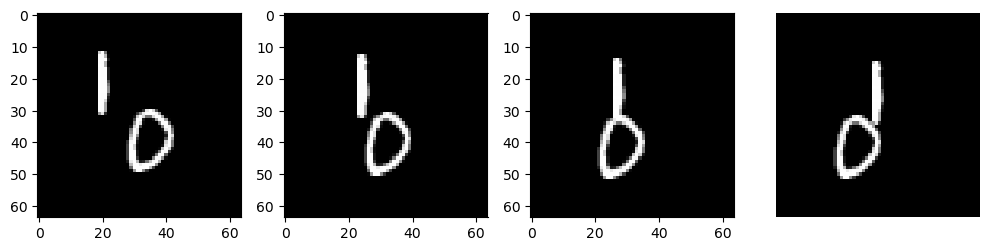

In [ ]:
all = [sample_x[0,i,:,:,0] for i in range(3)]+[sample_y[0,0,:,:,0]]
show_list(all)

In [ ]:
train_gen = image_generator(trainset)
val_gen = image_generator(valset)
test_gen = image_generator(testset)

In [ ]:
sample_x, sample_y = next(train_gen)

# Model Construction

LSTM (Long Short Term Memory) is a Recurrent Neural Network architecture. In this kind of architecture, the model passes the previous hidden state to the next step of the sequence. Therefore holding information on previous data the network has seen before and using it to make decisions. In other words, the data order is extremely important.
In this case, with sequencial images, one approach is using ConvLSTM layers. It is a Recurrent layer, just like the LSTM, but internal matrix multiplications are exchanged with convolution operations.

To build a Convolutional LSTM model, I will use the ConvLSTM2D layer, which will accept inputs of shape (batch_size, num_frames, width, height, channels), and return a prediction movie of the same shape.

In [ ]:
train_gen = image_generator(trainset)
val_gen = image_generator(valset)
test_gen = image_generator(testset)

print(next(train_gen)[0].shape)

(16, 3, 64, 64, 1)


The architecture I have decided to use consists of multiple `ConvLSTM2D` layers with batch normalization and a final `Conv3D` layer for spatiotemporal data processing. Each ConvLSTM2D layer processes spatiotemporal data and captures temporal dependencies between frames, while the batch normalization layers help with normalization and regularization (better convergence during training). I have decided, after sever trial to use four ConvLSTM2D layers applied successively with increasing complexity.

In [ ]:
# Define the input shape
input_shape = (None, 64, 64, 1)

# Input layer
inputs = layers.Input(shape=input_shape)

# First ConvLSTM2D layer with batch normalization
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(7, 7),
    padding="same",
    return_sequences=True,
    activation="relu"
)(inputs)
x = layers.BatchNormalization()(x)

# Second ConvLSTM2D layer with batch normalization
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(5, 5),
    padding="same",
    return_sequences=True,
    activation="relu"
)(x)
x = layers.BatchNormalization()(x)

# Third ConvLSTM2D layer with batch normalization
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=True,
    activation="relu"
)(x)
x = layers.BatchNormalization()(x)

# Fourth ConvLSTM2D layer with batch normalization
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=True,
    activation="relu"
)(x)
x = layers.BatchNormalization()(x)

# Fifth ConvLSTM2D layer
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(1, 1),
    padding="same",
    return_sequences=True,
    activation="relu"
)(x)

# Conv3D layer for spatiotemporal outputs
x = layers.Conv3D(
    filters=1,
    kernel_size=(3, 3, 3),
    activation="sigmoid",
    padding="same"
)(x)

# Lambda layer to select the last frame of each sequence
x = layers.Lambda(lambda x: x[:, -1, :, :, :])(x)

# Reshape layer to adjust the shape of the tensor
output = layers.Reshape((1, 64, 64, 1))(x)

# Create the model
model = keras.models.Model(inputs=inputs, outputs=output)


As kernel size for first layer I tried both 7x7 and 9x9, before the 5x5. The best result was obtained with 7x7, since, a 9x9 kernel has a larger convolution window (it can capture larger spatial features in the input data) than a 7x7 kernel (it may allow to capture finer details in the images). Each additional layer allows the model to learn and extract higher-level features from the input. I have tried this model with several combination of the kernel size (some combination are listed in the last section of this notebook).

The model I have decided to use consists of several layers:
- The input shape is defined as (None, 64, 64, 1), indicating a variable-length sequence of 2D images with a size of 64x64 pixels and a single channel. The input layer is created using the defined input shape.

- The first layer is a ConvLSTM2D
layer with 64 filters, a kernel size of (7, 7), and "same" padding (to keep the output size the same as the input). It returns sequences True, meaning it preserves the temporal dimension (to return the output for each time step in the sequence). The activation function is ReLU. It takes input with shape (None, 64, 64, 1), where None represents a variable-length sequence of 2D images with a size of 64x64 and a single channel (grayscale).

- After the ConvLSTM2D layer, there is a BatchNormalization layer. It normalizes the activations of the previous layer along the batch dimension. It helps mitigate covariate shift issues and speeds up model training.

- The second layer is another ConvLSTM2D layer with 64 filters, a kernel size of (5, 5), and "same" padding. It also returns sequences and uses the ReLU activation function.

- Another BatchNormalization layer follows the second ConvLSTM2D layer.

- The third ConvLSTM2D layer also follows a similar structure, but with a smaller 3x3 kernel size.

- Another BatchNormalization layer follows the Third ConvLSTM2D layer.

- The fourth ConvLSTM2D layer is another 3x3 kernel size. The addition of an additional 3x3 layer in this network aims to introduce another convolution operation to extract more complex features and further refine the data representation. In the specified network, the ConvLSTM2D layers are used to model spatiotemporal relationships within the input data. Each ConvLSTM2D layer uses a specific-sized kernel to perform spatial and temporal convolution operations on the input data. Adding an additional 3x3 layer allows the network to perform another convolution operation to further refine the representation of the features extracted by the previous layers, improving the network's ability to capture meaningful information in the input data and enhance the overall performance of the model. The early layers tend to extract basic features such as edges and lines, while the subsequent layers combine these basic features to recognize more complex shapes and spatiotemporal structures.

- Another BatchNormalization layer follows the fourth ConvLSTM2D layer.

- The fifth layer is a ConvLSTM2D layer similar to the previous one but with a kernel size of (1, 1), which means it operates on a single frame in the sequence and acts as a spatial attention mechanism. This layer helps refine the features learned by previous layers.

- Finally, there is a Conv3D layer (used for spatiotemporal outputs)with a kernel size of (3, 3, 3). It has a single filter and uses the sigmoid activation function. The Conv3D layer performs three-dimensional convolution on its input. It applies a set of filters to a 3D input volume, which can be thought of as a sequence of 2D images over time. The purpose of this layer is to extract spatiotemporal features from the input data.

- A Lambda layer is added to extract the final frame of the sequence. It selects the last frame along the time dimension. The lambda function x[:,-1,:,:,:] selects the last frame along the time dimension, discarding earlier frames.

- A Reshape layer is added to change the shape of the output tensor to (1, 64, 64, 1). This reshaping might be necessary depending on the requirements of the subsequent layers or the desired output shape.

- In the end, a model is created with the defined inputs and outputs using the Model class from Keras.

Without the Lambda and the reshape layer I have obtained an higher MSE because the first two frame generated by the Conv3D are not so good and make the result worse.

These layers together form the model architecture that processes spatiotemporal data using ConvLSTM and Conv3D layers, selecting the last frame of each sequence and adjusting the tensor shape as needed. The model takes 5D input with shape (batch_size, timesteps, width, height, channels) and produces a 5D output with shape (batch_size, timesteps, height, width, 1).

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 64, 64, 1)  0         
                             ]                                   
                                                                 
 conv_lstm2d (ConvLSTM2D)    (None, None, 64, 64, 64)  815616    
                                                                 
 batch_normalization (BatchN  (None, None, 64, 64, 64)  256      
 ormalization)                                                   
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, None, 64, 64, 64)  819456    
                                                                 
 batch_normalization_1 (Batc  (None, None, 64, 64, 64)  256      
 hNormalization)                                                 
                                                             

In [ ]:
# Compile the model
model.compile(
    loss=keras.losses.binary_crossentropy, # Binary cross-entropy loss function
    optimizer=keras.optimizers.Adam(), # Adam optimizer
    metrics=[keras.metrics.MeanSquaredError()] # Mean Squared Error metric
)

The code written above compiles the defined model by configuring its loss function (I have used the Binary Crossentropy), optimizer, and evaluation metrics. Once the model is compiled, it is ready for training using the fit() function with the specified loss, optimizer, and metrics settings.

# Model Training

With the model and data constructed, I can now train the model.

In [ ]:
# Define modifiable training hyperparameters
epochs = 60 # Number of training epochs
batch_size = 16 # Batch size for training

I have opted for a batch size of size 16 because, after some attemps, I have noticed that in this way I have a good generalization (a batch size allows the model to see more diverse examples in each training iteration and increased  the diversity can help the model generalize better by learning from a wider range of samples within each batch).

After several attempts I decided to use 60 epochs (due to early stopping they are often carried out between 45 and 55 epochs since the values tend to stabilize) as it turns out to be a good compromise between efficiency and a good result. The number of epochs is sufficient to allow the model to converge to a stable and optimal solution, further training not provide significant benefits (there is minimal improvement (changes only in the third and fourth digits after the decimal point)) and could lead to overfitting (if the model starts to overfit, where the training performance continues to improve while the validation performance plateaus or starts to degrade (indication that the model has learned too much from the training data and is not generalizing well)).

In [ ]:
# Define some callbacks to improve training.
early_stopping = keras.callbacks.EarlyStopping(monitor="val_mean_squared_error", patience=10)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_mean_squared_error", patience=5)

- *early_stopping*: This line creates an EarlyStopping callback. The EarlyStopping callback monitors the val_mean_squared_error during training and stops the training process if the validation loss does not improve for a certain number of epochs specified by the patience parameter. In this case, the training will be stopped if the validation loss does not improve for 10 consecutive epochs.

- *reduce_lr*: This line creates a ReduceLROnPlateau callback. The ReduceLROnPlateau callback reduces the learning rate (lr) of the optimizer when the validation loss does not improve for a certain number of epochs specified by the patience parameter. Reducing the learning rate can help the model to converge to a better solution. In this case, the learning rate will be reduced if the validation loss does not improve for 5 consecutive epochs.

The model.fit() function starts the training process with the specified parameters, including the data generators, number of epochs, batch size, and callbacks. During training, the model will iterate over the training data, compute gradients, update the model's parameters, and evaluate the performance on the validation data.

In [ ]:
# Fit the model to the training data.
model.fit(
    x=train_gen, # Training data generator
    steps_per_epoch=len(trainset) // batch_size, # Number of steps (batches) per epoch
    epochs=epochs, # Number of training epochs
    validation_data=val_gen, # Validation data generator
    validation_steps=len(valset) // batch_size, # Number of validation steps (batches)
    callbacks=[early_stopping, reduce_lr], # List of callbacks to be used during training
)

Epoch 1/60
500/500 [==============================] - 245s 445ms/step - loss: 0.0813 - mean_squared_error: 0.0193 - val_loss: 0.2122 - val_mean_squared_error: 0.0323 - lr: 0.0010
Epoch 2/60
500/500 [==============================] - 222s 445ms/step - loss: 0.0665 - mean_squared_error: 0.0144 - val_loss: 0.0660 - val_mean_squared_error: 0.0141 - lr: 0.0010
Epoch 3/60
500/500 [==============================] - 222s 444ms/step - loss: 0.0627 - mean_squared_error: 0.0130 - val_loss: 0.0624 - val_mean_squared_error: 0.0128 - lr: 0.0010
Epoch 4/60
500/500 [==============================] - 222s 445ms/step - loss: 0.0613 - mean_squared_error: 0.0125 - val_loss: 0.0661 - val_mean_squared_error: 0.0144 - lr: 0.0010
Epoch 5/60
500/500 [==============================] - 222s 443ms/step - loss: 0.0603 - mean_squared_error: 0.0122 - val_loss: 0.0607 - val_mean_squared_error: 0.0122 - lr: 0.0010
Epoch 6/60
500/500 [==============================] - 222s 445ms/step - loss: 0.0586 - mean_squared_error

# Evaluate the model on the test set

In [ ]:
# Evaluate the model on the test set
test_gen_loss = model.evaluate(test_gen, steps=len(testset) // batch_size)
print("Mean Squared Error on the test set:", test_gen_loss)

62/62 [==============================] - 10s 157ms/step - loss: 0.0406 - mean_squared_error: 0.0089
Mean Squared Error on the test set: [0.04060353711247444, 0.00888848677277565]


I chose to use this model because it generated a lower Mean Squared Error (under 0.01), a good predicted image (the result is optimal only in the case of overlapping numbers) and, compared to other models I tested it is a good compromise between execution time (related to the number of parameters used), predicted image quality and mean squared error. It takes less time and has a reduced number of total parameters thus reducing the overall cost of the network.

# Predicted Output

1/1 [==============================] - 0s 31ms/step
(16, 1, 64, 64, 1)


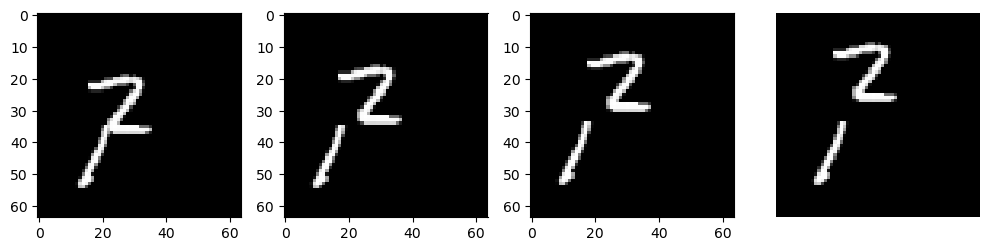

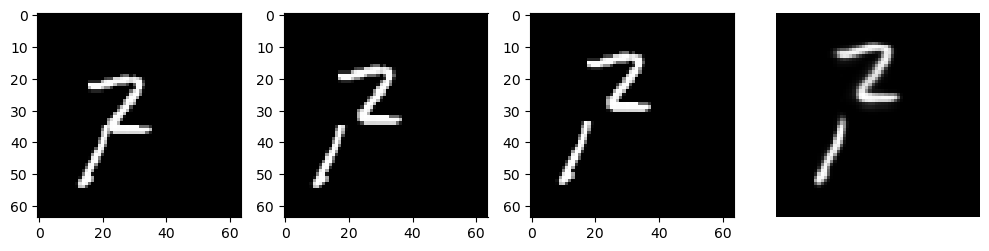

In [ ]:
# Generate a sample batch of test data
sample_x,sample_y=next(test_gen)

# Make predictions using the trained model
new_prediction=model.predict(sample_x)

# Print the shape of the new predictions
print(new_prediction.shape)

# Prepare a list of images for visualization
all = [sample_x[0,i,:,:,:] for i in range(3)]+[sample_y[0,0,:,:,0]]

# Display the list of images using the show_list function
show_list(all)

# Prepare a new list of images with the predicted output
all = [sample_x[0,i,:,:,:] for i in range(3)]+[new_prediction[0,0,:,:,0]]

# Display the list of images with the predicted output
show_list(all)

# Some previous attempts

- I tried to stack a combination of Conv2D and LSTM layers. The Conv2D layers capture spatial information from the input frames, while the LSTM layer captures the temporal dependencies between frames. The final Conv2D layer with a sigmoid activation is used to generate the predicted frame. But in this situation I have obtained an higher value of the mean squared error.

- I tried to change the number of batch_size but I have obtained a worst result

- I have tried to implement the Convolutional LSTM model in a sequential way.
The result provided by this architecture was similar to the one of that I have decided to use. The code defines the architecture of a model using the Keras Sequential API that allows to stack layers sequentially, making it easy to build models layer by layer. The Sequential model is used to stack these layers in the specified order to create the desired model architecture. Adding multiple layers in the model can potentially help in capturing more complex patterns and representations in the data. Each additional layer allows the model to learn and extract higher-level features from the input. I have tried this model with several combination of the kernel size.
> I also performed all the attempts described below with the chosen functional model, I don't report all the codes because it would be unnecessarily verbose (they change only by the number of layers).
>> For example I have tried a 9x9 before the 7x7 (very high computational cost given by the large number of parameters used (over 4 million parameters), but without major improvements in the value of the mean square error), a 9x9 before the 5x5 without the 7x7 (In this case I have obtained a good mean square error, almost equal to the one of the model I have considered but with an higher computational cost due to the higher number of parameters (2,793,665 respect to the 2,261,185 of the 7x7 model)), another 3x3 after the 5x5 (with and without the 7x7 layer). In the model with the two ConvLSTM2D layers with a kernel size of 3x3 (without the 7x7 layer) in the code serve to process the data sequences in more detail and capture finer spatial features (I have obtainded a good MSE on the test set (little bit higher
(never under 0.01 MSE with 40 epochs) that the one of the model I have considerd).

In [ ]:
# Define the model architecture

# Constructing the model using a Sequential API
model1 = keras.Sequential([
    # First ConvLSTM2D layer with batch normalization
    layers.ConvLSTM2D(
        filters=64,
        kernel_size=(7, 7),
        padding="same",
        return_sequences=True,
        activation="relu",
        input_shape=(None, 64, 64, 1)
    ),
    layers.BatchNormalization(),

    # Second ConvLSTM2D layer with batch normalization
    layers.ConvLSTM2D(
      filters=64,
      kernel_size=(5, 5),
      padding="same",
      return_sequences=True,
      activation="relu",
    ),
    layers.BatchNormalization(),

    # Third ConvLSTM2D layer with batch normalization
    layers.ConvLSTM2D(filters=64,
      kernel_size=(3, 3),
      padding="same",
      return_sequences=True,
      activation="relu",
    ),
    layers.BatchNormalization(),

    # Fourth ConvLSTM2D layer
    layers.ConvLSTM2D(filters=64,
      kernel_size=(1, 1),
      padding="same",
      return_sequences=True,
      activation="relu",
    ),

    # Conv3D layer for spatiotemporal outputs
    layers.Conv3D(
      filters=1,
      kernel_size=(3, 3, 3),
      activation="sigmoid",
      padding="same"
    )
])

- Another model that I have tried is the following in which I have obtained MSE=0.0095 and a good prediction:

In [ ]:
# Define the input shape
input_shape = (None, 64, 64, 1)

# Input layer
inputs = layers.Input(shape=input_shape)

# First ConvLSTM2D layer with batch normalization
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(9, 9),
    padding="same",
    return_sequences=True,
    activation="relu"
)(inputs)
x = layers.BatchNormalization()(x)

# Second ConvLSTM2D layer with batch normalization
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(5, 5),
    padding="same",
    return_sequences=True,
    activation="relu"
)(x)
x = layers.BatchNormalization()(x)

# Third ConvLSTM2D layer with batch normalization
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=True,
    activation="relu"
)(x)
x = layers.BatchNormalization()(x)

# Fourth ConvLSTM2D layer with batch normalization

x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(1, 1),
    padding="same",
    return_sequences=True,
    activation="relu"
)(x)

# Conv3D layer for spatiotemporal outputs
x = layers.Conv3D(
    filters=1,
    kernel_size=(3, 3, 3),
    activation="sigmoid",
    padding="same"
)(x)

# Lambda layer to select the last frame of each sequence
x = layers.Lambda(lambda x: x[:, -1, :, :, :])(x)

# Reshape layer to adjust the shape of the tensor
output = layers.Reshape((1, 64, 64, 1))(x)

# Create the model
model2 = keras.models.Model(inputs=inputs, outputs=output)

- I have tried also a different approach with a stack of Conv2D and MaxPooling layers, but I have obtained a worst result:

In [ ]:
model3 = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(64, 64, 3)),
    layers.MaxPooling2D((2, 2), padding='same'),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2), padding='same'),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2), padding='same'),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.UpSampling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.UpSampling2D((2, 2)),
    layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')
])

- Another model that I have tried is the following (I am attaching only the modified part of the code, the fit function remained unchanged. I have also tried this model in a non sequetial way (the code is similar to the following one)) in which I have increased the number of filters for the ConvLSTM2D layers and added a fourth ConvLSTM2D layer with 256 filters because, generally, increasing the number of filters can help the model capture more complex representations of the data.
I have used a smaller kernel size (3x3) for the subsequent ConvLSTM2D layers. This can allow the model to consider finer details in the input data.
> The obtained value of mean squared error is almost identical to the 3 ConvLSTM2D model (with 5x5,3x3,1x1 layers), the only difference is that this model need higher time to be computed, since it work with Total params: 6,030,849 instead of Total params: 746,689 given by the 3 ConvLSTM2D model.

In [ ]:
model4 = keras.Sequential([
    layers.ConvLSTM2D(
        filters=64,
        kernel_size=(5, 5),
        padding="same",
        return_sequences=True,
        activation="relu",
        input_shape=(None, 64, 64, 1)
    ),
    layers.BatchNormalization(),

    layers.ConvLSTM2D(
        filters=128,
        kernel_size=(3, 3),
        padding="same",
        return_sequences=True,
        activation="relu"
    ),
    layers.BatchNormalization(),

    layers.ConvLSTM2D(
        filters=128,
        kernel_size=(3, 3),
        padding="same",
        return_sequences=True,
        activation="relu"
    ),
    layers.BatchNormalization(),

    layers.ConvLSTM2D(
        filters=256,
        kernel_size=(3, 3),
        padding="same",
        return_sequences=True,
        activation="relu"
    ),
    layers.BatchNormalization(),

    layers.Conv3D(
        filters=1,
        kernel_size=(3, 3, 3),
        activation="sigmoid",
        padding="same"
    )
])